In [33]:
%matplotlib inline
import numpy as np
import pylab as pl

from psi.application import get_default_io, get_default_calibration, get_calibration_file
from psi.controller import util
from psi.controller.calibration.api import FlatCalibration, PointCalibration
from psi.controller.calibration.util import load_calibration, psd, psd_df, db, dbtopa
from psi.controller.calibration import tone
from psi.core.enaml.api import load_manifest_from_file

frequencies = [250, 500, 1000, 2000, 4000, 8000, 16000, 32000]

io_file = get_default_io()
cal_file = get_calibration_file(io_file)
print(cal_file)
io_manifest = load_manifest_from_file(io_file, 'IOManifest')
io = io_manifest()
audio_engine = io.find('NI_audio')

channels = audio_engine.get_channels(active=False)
load_calibration(cal_file, channels)

mic_channel = audio_engine.get_channel('microphone_channel')
mic_channel.gain = 40

cal_mic_channel = audio_engine.get_channel('reference_microphone_channel')
cal_mic_channel.gain = 0

speaker_channel = audio_engine.get_channel('speaker_1')
print(speaker_channel.calibration)

c:\users\lbhb\projects\psi2\data\io\default\default.json


In [34]:
fixed_gain_result = tone.tone_sens(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name='speaker_1',
    ai_channel_names=['reference_microphone_channel', 'microphone_channel'],
    gains=-30,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

In [35]:
fixed_gain_result['norm_spl'].unstack('channel_name').eval('microphone_channel-reference_microphone_channel')

frequency
250.0     -3.214936
500.0     -0.928713
1000.0    -0.617545
2000.0    -0.597211
4000.0    -0.609537
8000.0    -0.608364
16000.0   -0.377281
32000.0   -0.231312
dtype: float64

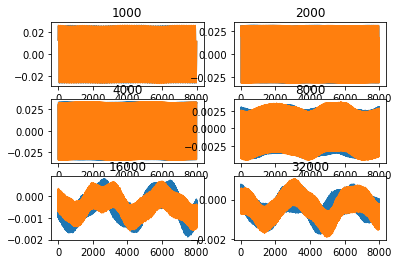

In [23]:
rms = fixed_gain_result.loc['reference_microphone_channel']['rms'].loc[1000]
figure, axes = pl.subplots(3, 2)

for ax, freq in zip(axes.ravel(), frequencies):
    w = fixed_gain_result.loc['microphone_channel', freq]['waveform'].T
    ax.plot(w)
    ax.set_title(freq)


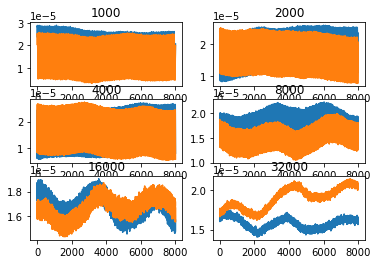

In [22]:
figure, axes = pl.subplots(3, 2)

for ax, freq in zip(axes.ravel(), frequencies):
    w = fixed_gain_result.loc['reference_microphone_channel', freq]['waveform'].T
    ax.plot(w)
    ax.set_title(freq)

In [6]:
tone_sens = fixed_gain_result.loc['microphone_channel', 'sens']
calibration = PointCalibration(tone_sens.index, tone_sens.values)
gains = calibration.get_gain(frequencies, 80)

In [7]:
variable_gain_result = tone.tone_spl(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name='speaker_1',
    ai_channel_names=['microphone_channel'],
    gains=gains,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

variable_gain_result['spl']

InvalidAttributeValueError: Requested value is not a supported value for this property. The property value may be invalid because it conflicts with another property.
Property: DAQmx_AO_Min
Requested Value: -2.034343e6
Maximum Value:  10.0
Minimum Value: -10.0
Channel Name: speaker_1

Task Name: NI_audio_hw_ao

Status Code: -200077
 in function DAQmxGetSampClkRate

In [ ]:
from psi.token.primitives import ChirpFactory

factory = ChirpFactory(fs=speaker_channel.fs,
                       start_frequency=500,
                       end_frequency=50000,
                       duration=0.02,
                       level=-40,
                       calibration=FlatCalibration.as_attenuation())

n = factory.get_remaining_samples()
chirp_waveform = factory.next(n)

result = util.acquire(audio_engine, chirp_waveform, 'speaker_1', ['microphone_channel'], repetitions=64, trim=0)

In [ ]:
chirp_response = result['microphone_channel'][0]
chirp_psd = psd_df(chirp_response, mic_channel.fs)
chirp_psd_mean = chirp_psd.mean(axis=0)
chirp_psd_mean_db = db(chirp_psd_mean)

signal_psd = db(psd_df(chirp_waveform, speaker_channel.fs))

freq = chirp_psd.columns.values
chirp_spl = mic_channel.calibration.get_spl(freq, chirp_psd)
chirp_spl_mean = chirp_spl.mean(axis=0)
chirp_sens = signal_psd - chirp_spl_mean - db(20e-6)

In [ ]:
chirp_sens.loc[1000]

In [ ]:
figure, axes = pl.subplots(1, 3, figsize=(12, 3))

chirp_response_mean = np.mean(chirp_response, axis=0)
print(chirp_response_mean.min(), chirp_response_mean.max())
axes[0].plot(chirp_response_mean)

freq = chirp_spl_mean.index.values
axes[1].semilogx(freq[1:], chirp_spl_mean[1:])
x = psd_df(chirp_response_mean, mic_channel.fs)
y = mic_channel.calibration.get_spl(x.index, x.values)
axes[1].semilogx(freq[1:], y[1:], 'r')
axes[1].axis(xmin=500, xmax=50000)

axes[2].semilogx(freq[1:], chirp_sens[1:])
axes[2].plot(tone_sens, 'ko')
axes[2].axis(xmin=500, xmax=50000)